In [255]:
import pandas as pd

df = pd.read_csv("D:\kaggle\pet adoption\pet_adoption_data.csv")
df_numeric = df
df_validation = df
df_rfe = df
df.head()

<>:3: SyntaxWarning: invalid escape sequence '\k'
<>:3: SyntaxWarning: invalid escape sequence '\k'
C:\Users\acer\AppData\Local\Temp\ipykernel_8280\2488440063.py:3: SyntaxWarning: invalid escape sequence '\k'
  df = pd.read_csv("D:\kaggle\pet adoption\pet_adoption_data.csv")


,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,103,Black,Large,16.357608,1,0,43,335,0,0
1,501,Rabbit,Labrador,8,Black,Medium,12.625582,0,0,50,93,0,1
2,502,Dog,Parakeet,153,Gray,Small,9.624407,0,0,3,79,0,0
3,503,Bird,Golden Retriever,91,Gray,Medium,20.770021,0,0,59,37,1,0
4,504,Bird,Golden Retriever,174,Gray,Medium,7.025923,1,0,28,407,0,1


In [256]:
adopt = df[df['AdoptionLikelihood']==1]
no_adopt = df[df['AdoptionLikelihood']==0]
print("Number of Likely Adopted",adopt["PetID"].count())
print("Number of Unlikely Adopted",adopt["PetID"].count())

Number of Likely Adopted 679
Number of Unlikely Adopted 679


**CORRELATION**\
\
See the correlation of each feature against the target variable (Adoption Likelihood). The results do not provide much meaningful information because each feature has a low correlation with the target variable. Unless features *Vaccinated*, *HealthCondition*, *Breed*, and *AgeMonths* have a significant correlation with Adoption Likelihood rather than other features.

C:\Users\acer\AppData\Local\Temp\ipykernel_8280\3724118667.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y='Band', data=correlation_df, palette='viridis')


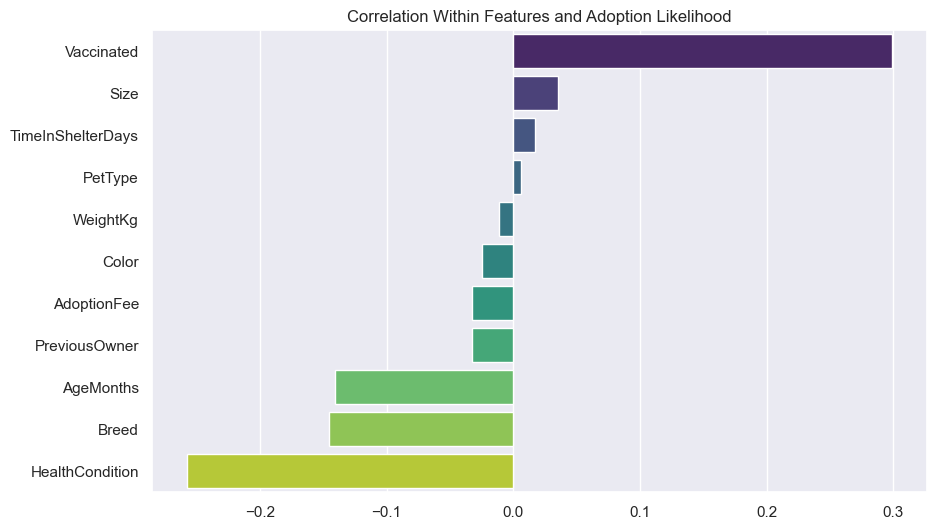

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['PetType'] = label_encoder.fit_transform(df['PetType'])
df['Breed'] = label_encoder.fit_transform(df['Breed'])
df['Color'] = label_encoder.fit_transform(df['Color'])
df['Size'] = label_encoder.fit_transform(df['Size'])

bands = ["PetType","Breed","AgeMonths","Color","Size","WeightKg","Vaccinated","HealthCondition","TimeInShelterDays","AdoptionFee","PreviousOwner"]
label = 'AdoptionLikelihood'

correlation_coefficients = {band: stats.pointbiserialr(df[band], df[label])[0] for band in bands}

correlation_df = pd.DataFrame(list(correlation_coefficients.items()), columns=['Band', 'Correlation'])

correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Band', data=correlation_df, palette='viridis')
plt.title("Correlation Within Features and Adoption Likelihood")
plt.xlabel("")
plt.ylabel('')
plt.show()

**FEATURES SELECTION**

**Boxplot**\
Using boxplot to compare distribution of numeric features for each label. The result shows that only *AgeMonths* feature has the significant difference on data distribution each label.

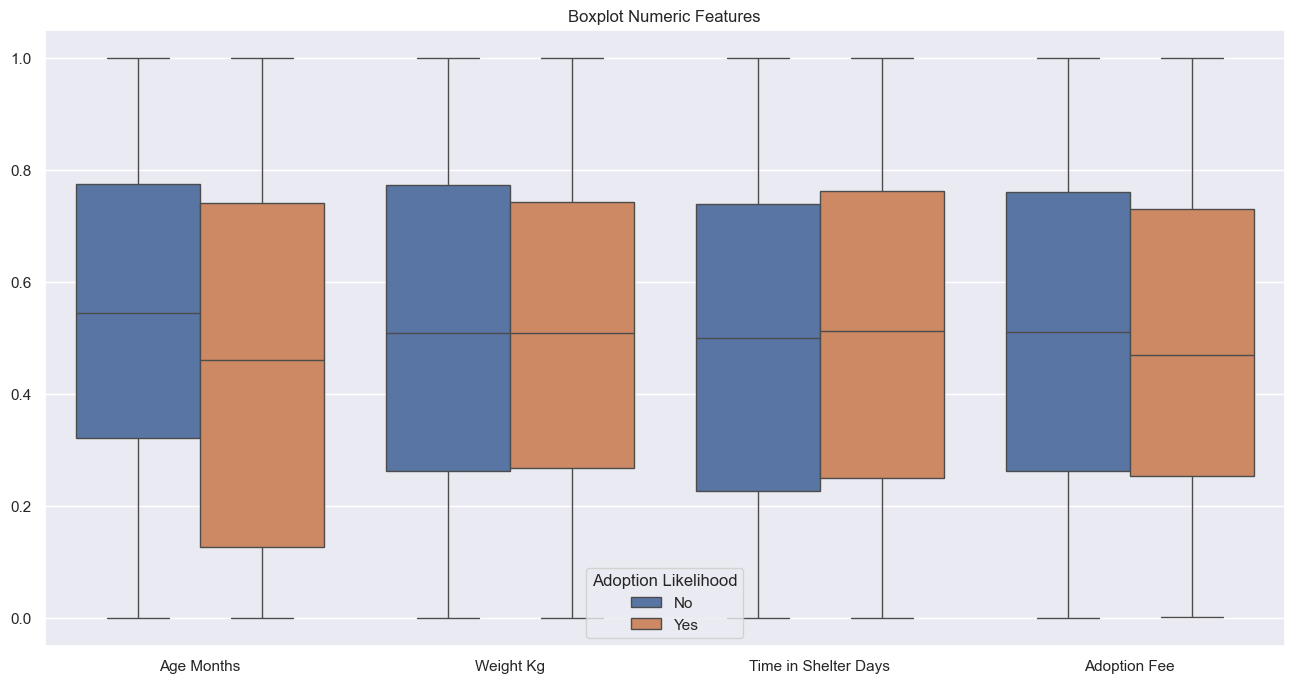

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df_numeric['Adoption Likelihood'] = df_numeric['AdoptionLikelihood'].replace({1: 'Yes', 0: 'No'})

scaler = MinMaxScaler()
df_numeric["Age Months"] = scaler.fit_transform(df_numeric[["AgeMonths"]])
df_numeric["Weight Kg"] = scaler.fit_transform(df_numeric[["WeightKg"]])
df_numeric["Time in Shelter Days"] = scaler.fit_transform(df_numeric[["TimeInShelterDays"]])
df_numeric["Adoption Fee"] = scaler.fit_transform(df_numeric[["AdoptionFee"]])

feature_names = ["Age Months","Weight Kg","Time in Shelter Days","Adoption Fee", "Adoption Likelihood"]

df_melted = pd.melt(df_numeric[feature_names], id_vars='Adoption Likelihood', var_name='Features', value_name='Value')

plt.figure(figsize=(16, 8))
sns.boxplot(x='Features', y='Value', hue='Adoption Likelihood', data=df_melted)
plt.title('Boxplot Numeric Features')
plt.xlabel('')
plt.ylabel('')
plt.show()

**ANOVA f-test**
\
ANOVA is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not.
\
\
An F-statistic, or F-test, is a class of statistical tests that calculate the ratio between variances values, such as the variance from two different samples or the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method is a type of F-statistic referred to here as an ANOVA f-test.
\
\
Importantly, ANOVA is used when one variable is numeric and one is categorical, such as numerical input variables and a classification target variable in a classification task.
\
\
The results of this test can be used for feature selection where those features that are independent of the target variable can be removed from the dataset.
\
\
source: https://machinelearningmastery.com/feature-selection-with-numerical-input-data/
\
\
**Result**\
The results are the same as the results of the previous analysis, namely the *AgeMonths* feature has a significant effect on determining the target class.

Feature AgeMonths: 31.922425
Feature WeightKg: 0.767915
Feature TimeInShelterDays: 0.314496
Feature AdoptionFee: 2.924052


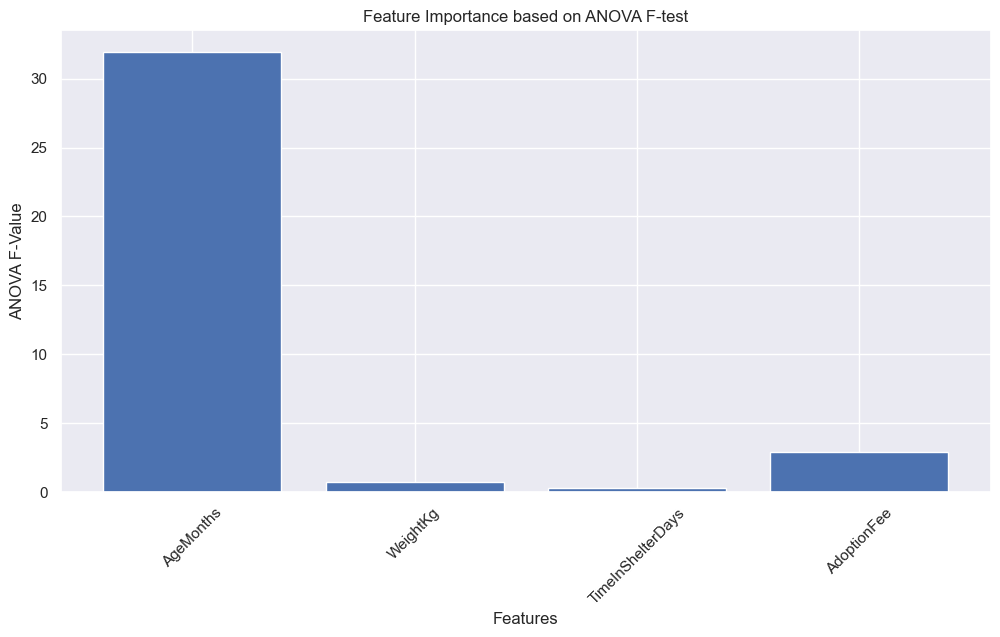

In [259]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = df_numeric[["AgeMonths","WeightKg","TimeInShelterDays","AdoptionFee"]]
y = df_numeric['AdoptionLikelihood']

def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=f_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (X.columns[i], fs.scores_[i]))
plt.figure(figsize=(12, 6))
plt.bar(X.columns, fs.scores_)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('ANOVA F-Value')
plt.title('Feature Importance based on ANOVA F-test')
plt.show()

**Chi-Square and P-Value**
- High Chi-Square value: Indicates that there is a strong dependency between the feature and the target. The feature may be important to the model.
- Low p-value (usually <0.05): Indicates that we can reject the null hypothesis. That is, there is a significant relationship between the feature and the target.\

So the main objective is, find feature that has high chi-square value and low p-value.\
The result is features *Breed*, *Vaccinated*, and *HealthCondition* are fulfill the requirements.

           Feature  Chi2_Score       P_Value
0          PetType    0.057446  8.105796e-01
1            Breed   48.883035  2.716907e-12
2            Color    1.256803  2.622571e-01
3             Size    1.656800  1.980359e-01
4       Vaccinated   52.642092  4.002192e-13
5  HealthCondition  106.256995  6.476685e-25
6    PreviousOwner    1.504276  2.200146e-01


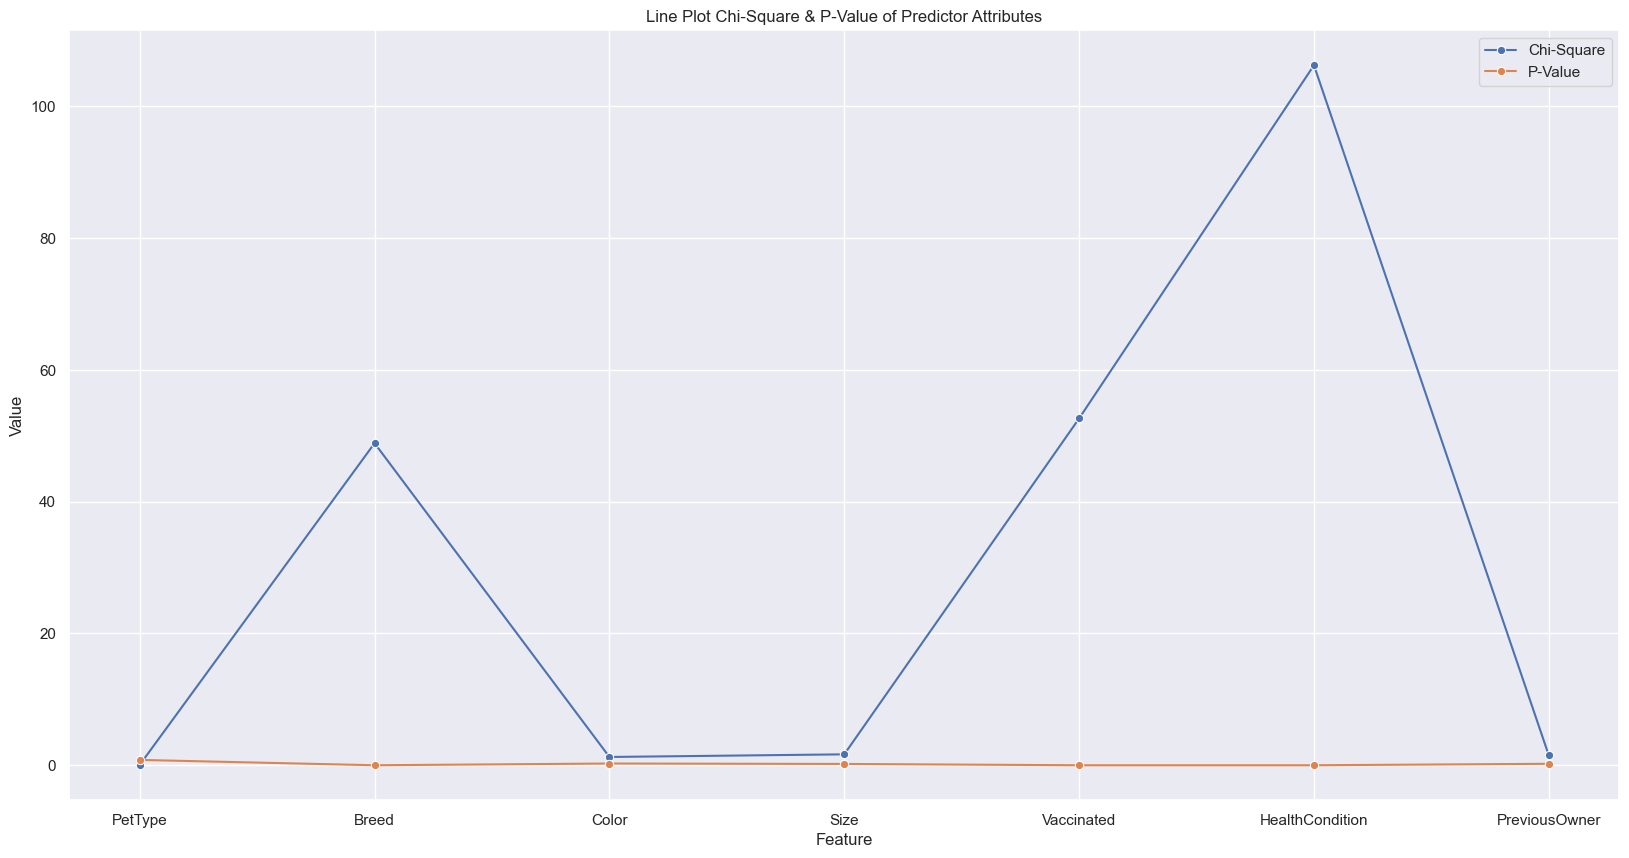

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2

X = df[["PetType","Breed","Color","Size","Vaccinated","HealthCondition","PreviousOwner"]]
y = df['AdoptionLikelihood']
chi2_scores, p_values = chi2(X, y)

chi2_results = pd.DataFrame({'Feature': ["PetType","Breed","Color","Size","Vaccinated","HealthCondition","PreviousOwner"],
                             'Chi2_Score': chi2_scores,
                             'P_Value': p_values})
print(chi2_results)

sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))  
sns.lineplot(data=chi2_results, x="Feature", y="Chi2_Score", marker='o', label="Chi-Square")
sns.lineplot(data=chi2_results, x="Feature", y="P_Value", marker='o', label="P-Value")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.title("Line Plot Chi-Square & P-Value of Predictor Attributes")
plt.legend()
plt.show()

**Feature Importance Random Forest Classifier**\
The goal is to find what features most influence the division of trees in the Random Forest Classifier algorithm.\
The result is features *Size*, *AgeMonths*, *Breed*, and *Vaccinated*

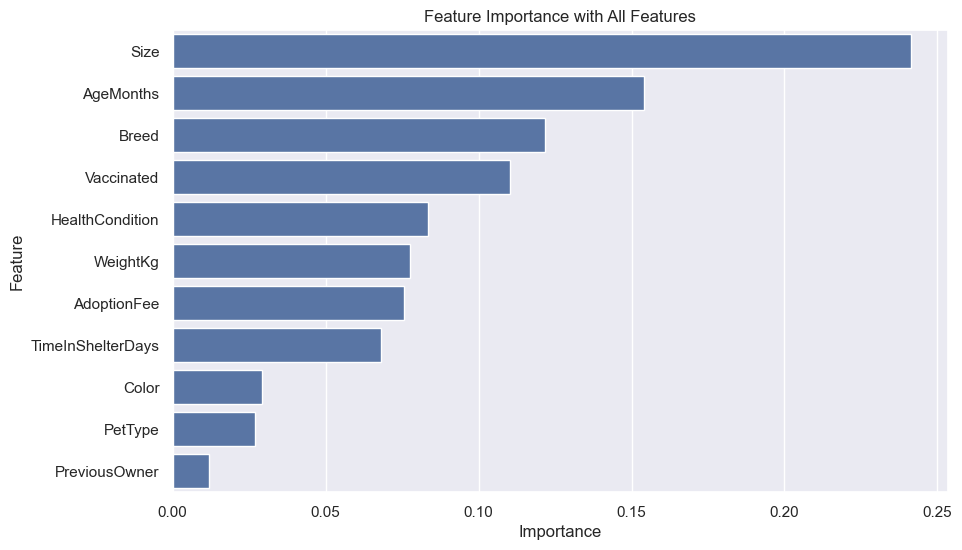

In [262]:
from sklearn.ensemble import RandomForestClassifier

X = df_rfe[["PetType","Breed","AgeMonths","Color","Size","WeightKg","Vaccinated","HealthCondition","TimeInShelterDays","AdoptionFee","PreviousOwner"]]
y = df_rfe['AdoptionLikelihood']

rf_all_features = RandomForestClassifier()
rf_all_features.fit(X, y)

importances = rf_all_features.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': ["PetType","Breed","AgeMonths","Color","Size","WeightKg","Vaccinated","HealthCondition","TimeInShelterDays","AdoptionFee","PreviousOwner"], 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance with All Features')
plt.show()


So the features selected in the feature selection process are features *Size*, *AgeMonths*, *Breed*, *Vaccinated*, and *HealthCondition*

**Measure The Influence of Each Feature on The Accuracy Value of The Model**

c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


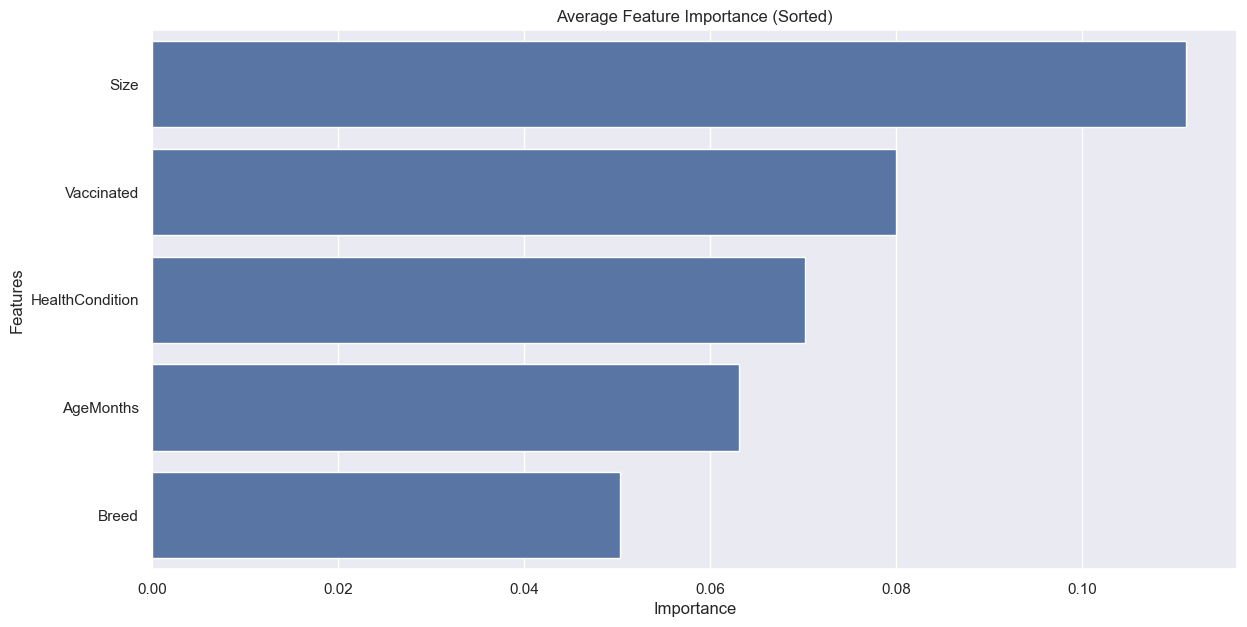

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

X = df[["Breed", "AgeMonths", "Vaccinated", "HealthCondition", "Size"]]
y = df['AdoptionLikelihood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

accuracy_results = []
feature_importance_values = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append((model_name, accuracy))
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    feature_importance_values.append(result.importances_mean)

accuracy_df = pd.DataFrame(accuracy_results, columns=['Model', 'Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

average_importance = np.mean(feature_importance_values, axis=0)

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': average_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Average Feature Importance (Sorted)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

**Find The Best Model for Classification**

c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


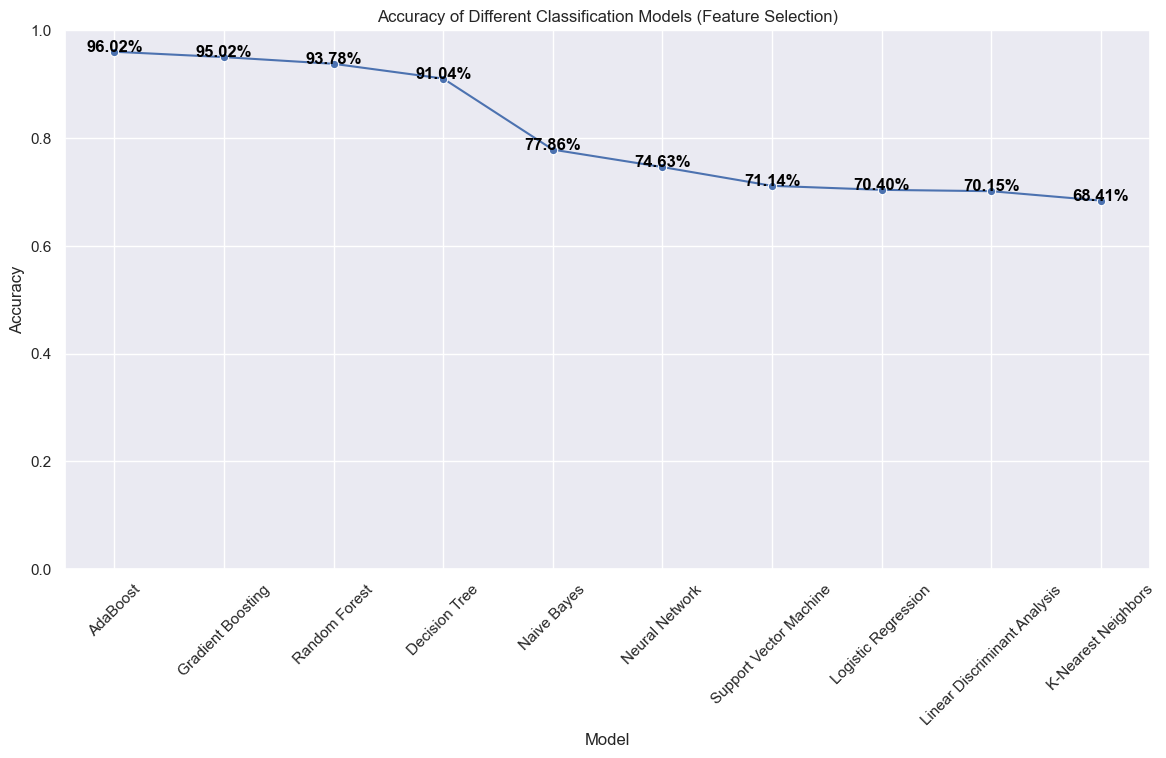

In [187]:
X = df[["Breed","AgeMonths","Vaccinated","HealthCondition","Size"]]
y = df['AdoptionLikelihood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

accuracy_results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append((model_name, accuracy))

accuracy_df = pd.DataFrame(accuracy_results, columns=['Model', 'Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 7))
sns.lineplot(data=accuracy_df, x='Model', y='Accuracy', marker='o')
for i, row in accuracy_df.iterrows():
    plt.text(i, row['Accuracy'], f"{row['Accuracy']*100:.2f}%", horizontalalignment='center', size='medium', color='black', weight='semibold')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classification Models (Feature Selection)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

**Hyperparameter Tuning Ada Boost Classifier**

In [190]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': np.linspace(0.01, 1, num=50),
    'estimator__max_depth': randint(1, 10),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 20)
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier())
random_search = RandomizedSearchCV(estimator=ada, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=1, n_jobs=-1, scoring='accuracy')
random_search.fit(X_train, y_train)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")

best_ada = random_search.best_estimator_
y_pred = best_ada.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found: {'estimator__max_depth': 1, 'estimator__min_samples_leaf': 16, 'estimator__min_samples_split': 12, 'learning_rate': 0.09081632653061224, 'n_estimators': 457}
Best cross-validation accuracy: 0.9514018691588785
Test accuracy: 0.9626865671641791


**Classification Report Ada Boost Classifier**

In [192]:
from sklearn.metrics import classification_report

best_ada.fit(X_train, y_train)
ada_pred = best_ada.predict(X_test)
print("Classification report")
print(classification_report(y_test,ada_pred))

c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       259
           1       0.96      0.94      0.95       143

    accuracy                           0.96       402
   macro avg       0.96      0.96      0.96       402
weighted avg       0.96      0.96      0.96       402



**Confusion Matrix Ada Boost Classifier**

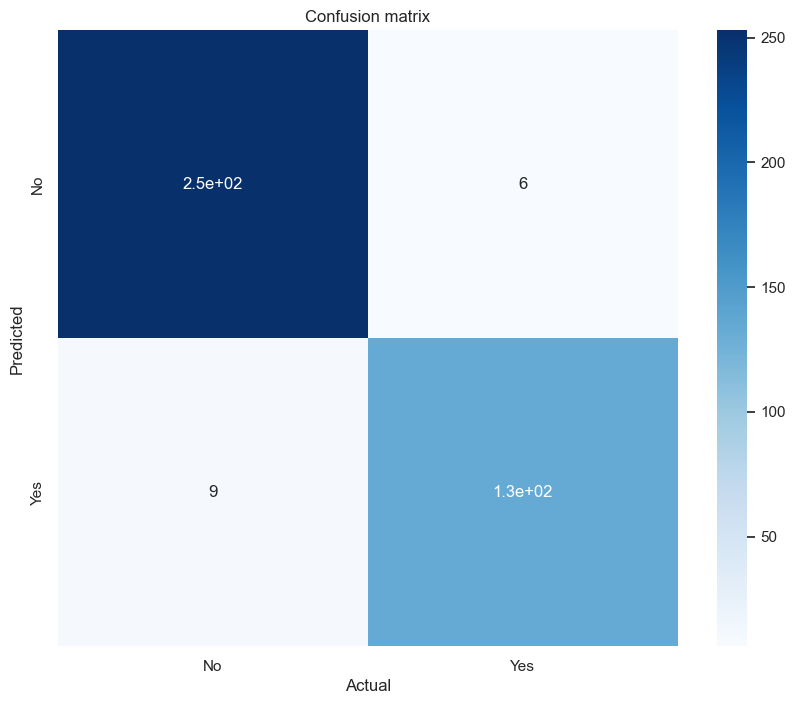

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

df['Label'] = df['AdoptionLikelihood'].replace({1: 'Yes', 0: 'No'})

aux_df = df[['Label', 'AdoptionLikelihood']].drop_duplicates().sort_values('AdoptionLikelihood')
conf_matrix = confusion_matrix(y_test, ada_pred)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Label'].values, 
            yticklabels=aux_df['Label'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

**Try to Use All Features**\
2 best model is **Random Forest Classifier** and **Gradient Boost Classifier**

c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


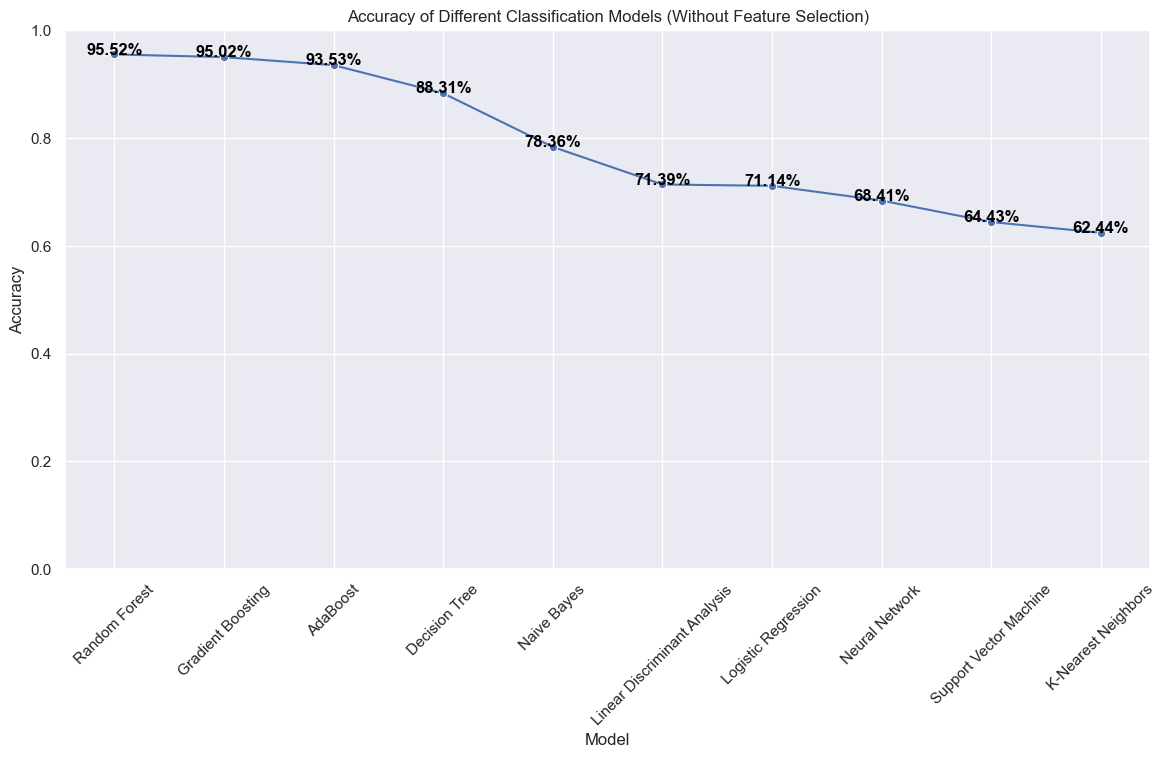

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

X = df[["PetType","Breed","AgeMonths","Color","Size","WeightKg","Vaccinated","HealthCondition","TimeInShelterDays","AdoptionFee","PreviousOwner"]]
y = df['AdoptionLikelihood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

accuracy_results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append((model_name, accuracy))

accuracy_df = pd.DataFrame(accuracy_results, columns=['Model', 'Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 7))
sns.lineplot(data=accuracy_df, x='Model', y='Accuracy', marker='o')
for i, row in accuracy_df.iterrows():
    plt.text(i, row['Accuracy'], f"{row['Accuracy']*100:.2f}%", horizontalalignment='center', size='medium', color='black', weight='semibold')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classification Models (Without Feature Selection)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

**Hyperparameter Tuning Random Forest Classifier**

In [169]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=1, n_jobs=-1, scoring='accuracy')
random_search.fit(X_train, y_train)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


**Classification Report Random Forest Classifier**

In [170]:
from sklearn.metrics import classification_report, confusion_matrix

best_rf.fit(X_train, y_train)
rf_pred = best_rf.predict(X_test)
print("Classification report")
print(classification_report(y_test,rf_pred))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       259
           1       0.95      0.92      0.94       143

    accuracy                           0.96       402
   macro avg       0.95      0.95      0.95       402
weighted avg       0.96      0.96      0.96       402



**Confusion Matrix Random Forest Classifier**

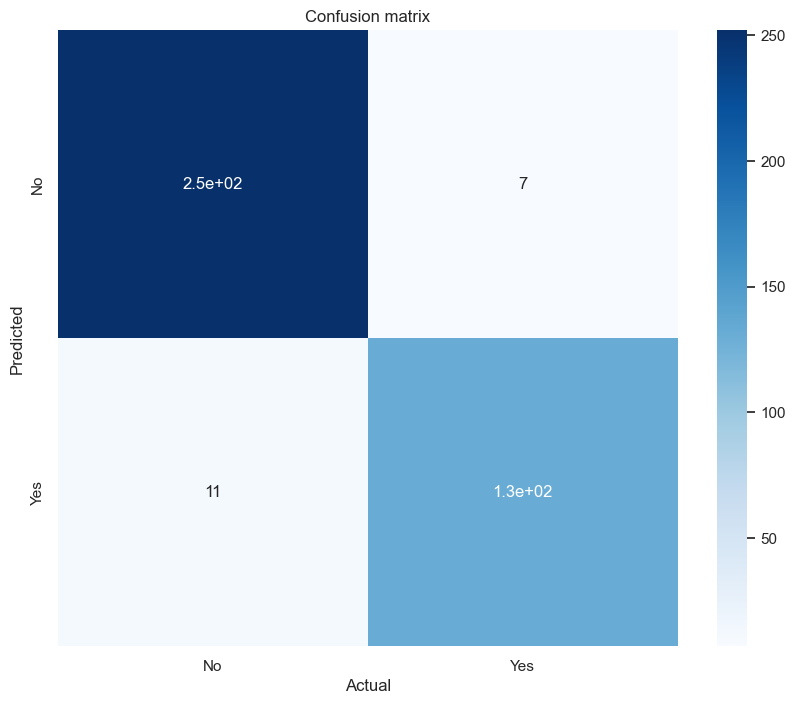

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Label'] = df['AdoptionLikelihood'].replace({1: 'Yes', 0: 'No'})

aux_df = df[['Label', 'AdoptionLikelihood']].drop_duplicates().sort_values('AdoptionLikelihood')
conf_matrix = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Label'].values, 
            yticklabels=aux_df['Label'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

**Hyperparameter Tuning Gradient Boost Classifier**

In [172]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint

param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

gb = GradientBoostingClassifier()
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_distributions, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=1, scoring='accuracy')
random_search.fit(X_train, y_train)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")

best_gb = random_search.best_estimator_
y_pred = best_gb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
78 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
58 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", 

Best parameters found: {'learning_rate': 0.02996094440623448, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 13, 'min_samples_split': 11, 'n_estimators': 282, 'subsample': 0.9793038799750675}
Best cross-validation accuracy: 0.9289719626168225
Test accuracy: 0.9527363184079602


**Classification Report Gradient Boost Classifier**

In [173]:
from sklearn.metrics import classification_report, confusion_matrix

best_gb.fit(X_train, y_train)
gb_pred = best_gb.predict(X_test)
print("Classification report")
print(classification_report(y_test,gb_pred))

Classification report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       259
           1       0.94      0.89      0.91       143

    accuracy                           0.94       402
   macro avg       0.94      0.93      0.93       402
weighted avg       0.94      0.94      0.94       402



**Confusion Matrix Gradient Boost Classifier**

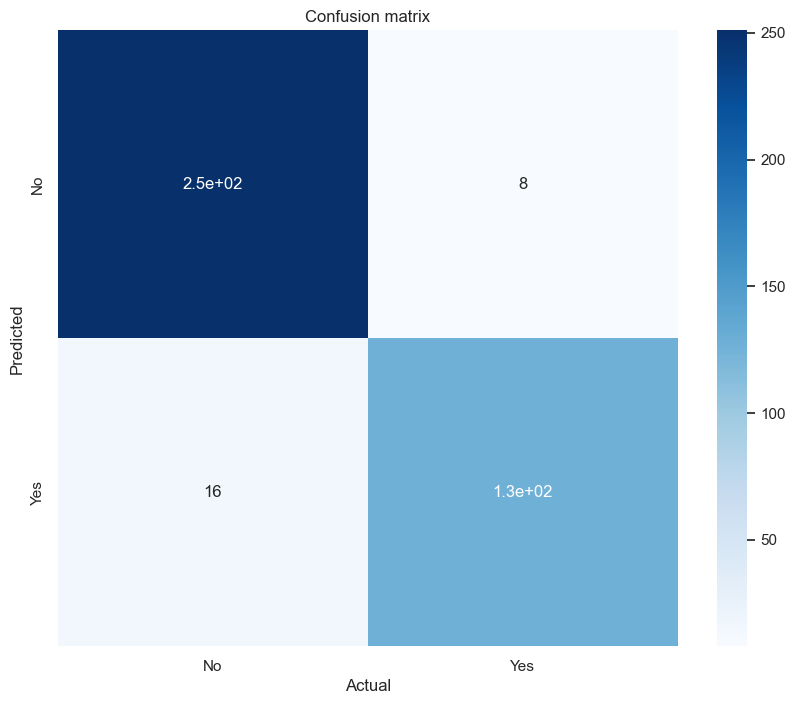

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Label'] = df['AdoptionLikelihood'].replace({1: 'Yes', 0: 'No'})

aux_df = df[['Label', 'AdoptionLikelihood']].drop_duplicates().sort_values('AdoptionLikelihood')
conf_matrix = confusion_matrix(y_test, gb_pred)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Label'].values, 
            yticklabels=aux_df['Label'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

**VALIDATION**\
Find the value of each important feature that most influences a pet's adoption rate.

In [242]:
import matplotlib.pyplot as plt

adopt = df_validation[df_validation['AdoptionLikelihood']==1]

**Medium-Sized Pets**

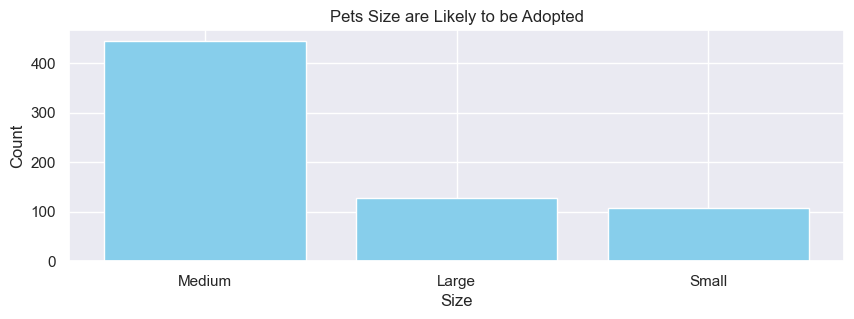

In [243]:
categories = adopt["Size"].unique()
values = adopt["Size"].value_counts()

plt.figure(figsize=(10, 3))  
plt.bar(categories, values, color='skyblue') 
plt.title('Pets Size are Likely to be Adopted')
plt.xlabel('Size')
plt.ylabel('Count')
plt.show()

**Vaccinated Pets**

C:\Users\acer\AppData\Local\Temp\ipykernel_8280\1463111238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopt['Vaccinated'] = adopt['Vaccinated'].replace({0: 'Vaccinated', 1: 'Not Vaccinated'})


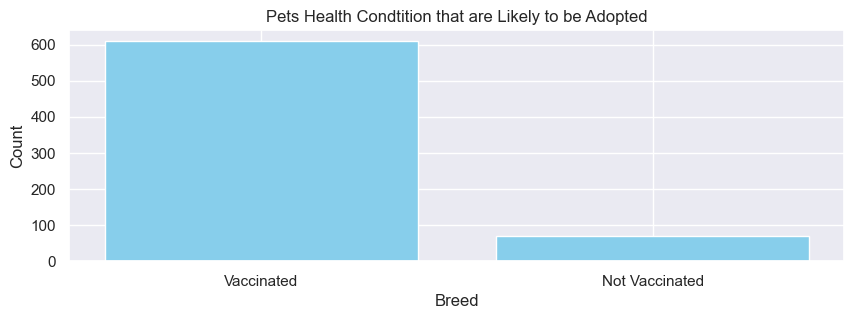

In [247]:
adopt['Vaccinated'] = adopt['Vaccinated'].replace({0: 'Vaccinated', 1: 'Not Vaccinated'})

categories = adopt["Vaccinated"].unique()
values = adopt["Vaccinated"].value_counts()

plt.figure(figsize=(10, 3))  
plt.bar(categories, values, color='skyblue') 
plt.title('Pets Vaccination Status that are Likely to be Adopted')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

**Healthy Pets**

C:\Users\acer\AppData\Local\Temp\ipykernel_8280\1002296257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopt['HealthCondition'] = adopt['HealthCondition'].replace({0: 'Healthy', 1: 'Medical Condition'})


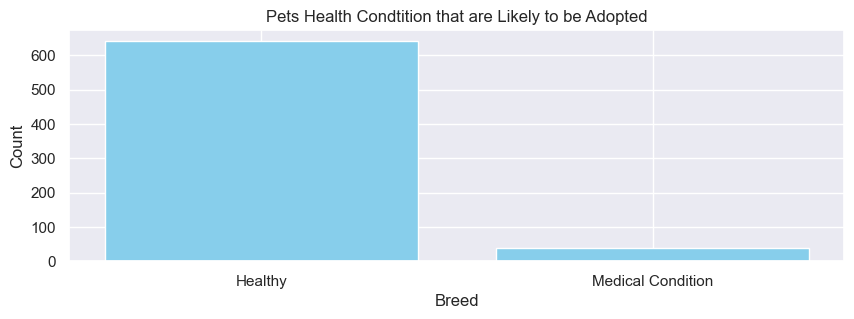

In [246]:
adopt['HealthCondition'] = adopt['HealthCondition'].replace({0: 'Healthy', 1: 'Medical Condition'})

categories = adopt["HealthCondition"].unique()
values = adopt["HealthCondition"].value_counts()

plt.figure(figsize=(10, 3))  
plt.bar(categories, values, color='skyblue') 
plt.title('Pets Health Condtition that are Likely to be Adopted')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

**Puppy, Kitten, Litle Bird, Bunny**

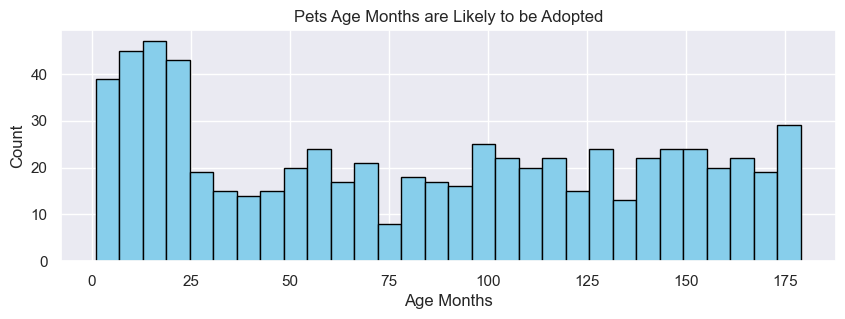

In [244]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.hist(adopt["AgeMonths"], bins=30, color='skyblue', edgecolor="black")
plt.title('Pets Age Months are Likely to be Adopted')
plt.ylabel('Count')
plt.xlabel('Age Months')
plt.show()

**Labrador Dog**

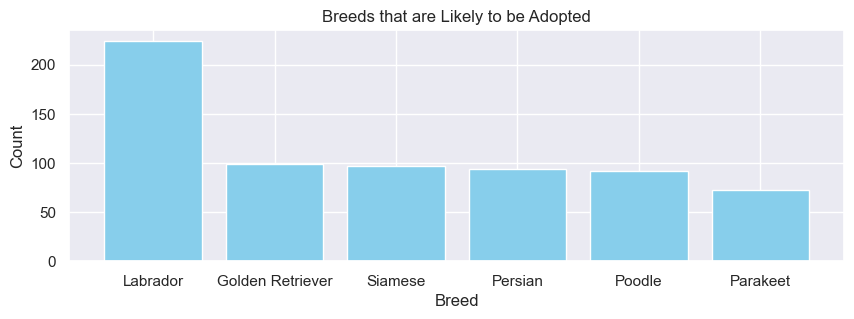

In [245]:
categories = adopt["Breed"].unique()
values = adopt["Breed"].value_counts()

plt.figure(figsize=(10, 3))  
plt.bar(categories, values, color='skyblue') 
plt.title('Breeds that are Likely to be Adopted')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

**CONCLUSION**
- The features that most influence the adoption rate are (most-least):\
**(Size - Vaccination - Health Condition - Age Months - Breed)**
- So the strategies to increase adoption rates in shelters:
1. The pets that have a medium size are more likely to be adopted. So increase the stock of medium-sized pets
2. The pets that already vaccinated are more likely to be adopted. So it is necessary to vaccinate all pets first before they are ready for adoption.
3. The pets that are healthy are more likely to be adopted. So it is necessary to ensure that the pet to be adopted is in good health.
4. The pets that have a small number of age months are more likely to be adopted. So provide more pets such as puppies, kittens, bunny, and others.
5. The labrador breed is the most likely pet to be adopted
- Using features from the feature selection result; between Ada Boost Classifier, Random Forest Classifier, and Gradient Boost Classifier the best model is **Ada Boost Classifier** with accuracy around **96%**:   

                 precision   recall  f1-score   support

           0        0.97      0.98      0.97       259
           1        0.96      0.94      0.95       143

      accuracy                          0.96       402
      macro avg     0.96      0.96      0.96       402
      weighted avg  0.96      0.96      0.96       402